First, we load the modules needed for analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
%matplotlib notebook

Next, we open the `.braidz` file and read a couple tables from it. We read the 2D detections into the Pandas DataFrame `df` and the clock information from the triggerbox into the DataFrame `clocks_df`.

In [2]:
archive = zipfile.ZipFile("20211019_171038.braidz", mode='r')
df = pd.read_csv(archive.open('data2d_distorted.csv.gz'),comment="#",compression='gzip')
clocks_df = pd.read_csv(archive.open('trigger_clock_info.csv.gz'),comment="#",compression='gzip')

Let's look at the 2D data dataframe:

In [3]:
df

,camn,frame,timestamp,cam_received_timestamp,device_timestamp,block_id,x,y,area,slope,eccentricity,frame_pt_idx,cur_val,mean_val,sumsqf_val
0,7,32190,1.634656e+09,1.634656e+09,1241179279577619,32567,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
1,8,32190,1.634656e+09,1.634656e+09,1241186770166104,32470,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2,5,32190,1.634656e+09,1.634656e+09,1241185975046934,32322,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
3,9,32190,1.634656e+09,1.634656e+09,1241176651040797,32395,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
4,6,32190,1.634656e+09,1.634656e+09,1241186066808197,32243,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30170,7,38224,1.634656e+09,1.634656e+09,1241186822149336,38601,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
30171,9,38224,1.634656e+09,1.634656e+09,1241184193598984,38429,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
30172,5,38224,1.634656e+09,1.634656e+09,1241193517658831,38356,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
30173,6,38224,1.634656e+09,1.634656e+09,1241193609422702,38277,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN


We want to compute a few extra columns based on the triggerbox clock information.

In [4]:
# The 'timestamp' is the average of the start and stop time. It indicates the best guess,
# assumming symmetric delays to and from the triggerbox device, of 
# the time at which the framestamp was grabbed.
clocks_df["timestamp"] = (clocks_df["start_timestamp"] + clocks_df["stop_timestamp"])/2

# We compute the time interval between initiating a request for receiving the framestamp
# and the time the request was received. This is thus the maximum measurement error.
clocks_df["dt"] = (clocks_df["stop_timestamp"] - clocks_df["start_timestamp"])

# We convert the integer framecount and 'tcnt' variables into a float representing the
# 'framestamp'. This is a clock that continually increases and emits a trigger pulse
# as it crosses integer values.
clocks_df["framestamp"] = clocks_df["framecount"] + clocks_df["tcnt"]/255.0

Now let's look at this dataframe, too.

In [5]:
clocks_df

,start_timestamp,framecount,tcnt,stop_timestamp,timestamp,dt,framestamp
0,1.634656e+09,32194,3,1.634656e+09,1.634656e+09,0.011038,32194.011765
1,1.634656e+09,32205,47,1.634656e+09,1.634656e+09,0.005183,32205.184314
2,1.634656e+09,32215,201,1.634656e+09,1.634656e+09,0.010992,32215.788235
3,1.634656e+09,32226,37,1.634656e+09,1.634656e+09,0.003296,32226.145098
4,1.634656e+09,32236,149,1.634656e+09,1.634656e+09,0.010766,32236.584314
...,...,...,...,...,...,...,...
575,1.634656e+09,38174,96,1.634656e+09,1.634656e+09,0.010743,38174.376471
576,1.634656e+09,38184,138,1.634656e+09,1.634656e+09,0.004994,38184.541176
577,1.634656e+09,38195,33,1.634656e+09,1.634656e+09,0.010976,38195.129412
578,1.634656e+09,38205,78,1.634656e+09,1.634656e+09,0.005079,38205.305882


Using this clock information, we can compute the gain and offset between the host computer's clock and the triggerbox frame clock.

In [6]:
def fit_time_model(framestamp, timestamp):
    A = []
    b = []
    for (f, t) in zip(framestamp, timestamp):
        A.append((f, 1.0))
        b.append(t)
    A = np.array(A)
    b = np.array(b)
    
    gain,offset = np.linalg.lstsq(A,b,rcond=None)[0]
    return (gain,offset)

(gain, offset) = fit_time_model(clocks_df['framestamp'], clocks_df['timestamp'])
print(gain,offset)

0.010000415046393384 1634655916.842692


Let's look at the model fit versus the data that went into making the fit.

<IPython.core.display.Javascript object>


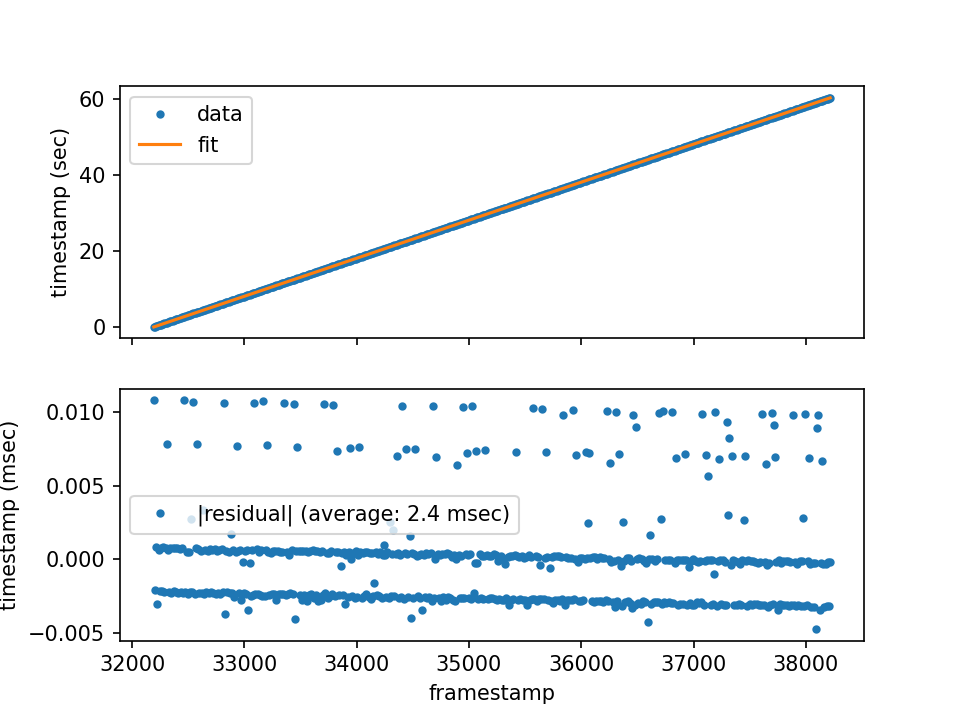

In [7]:
clock_ts0 = clocks_df["timestamp"].iloc[0]

fig, axes = plt.subplots(nrows=2, sharex=True)

ax0 = axes[0]
ax0.plot(clocks_df["framestamp"], clocks_df["timestamp"]-clock_ts0, '.', label="data" )
ax0.plot(clocks_df["framestamp"], clocks_df["framestamp"]*gain + offset - clock_ts0, '-', label="fit")
ax0.set_ylabel("timestamp (sec)")
ax0.legend()

residuals = np.array(clocks_df["timestamp"] - (clocks_df["framestamp"]*gain + offset))
av_residual = np.sum(abs(residuals))/len(residuals)
av_residual_msec = av_residual*1e3
axes[1].plot(clocks_df["framestamp"], residuals, '.', label="|residual| (average: %.1f msec)"%av_residual_msec )
axes[1].set_ylabel("timestamp (msec)")
axes[1].legend()

axes[-1].set_xlabel("frame");

Let's create a DataFrame (called `df1`) which has data only from a single camera.

In [8]:
df1 = df[df["camn"]==df["camn"].iloc[0]].copy()

Let's plot the various clock information. The `cam_received_timestamp` should lag the trigger time be some milliseconds and the recorded and recomputed trigger time should be very similar to each other.

<IPython.core.display.Javascript object>


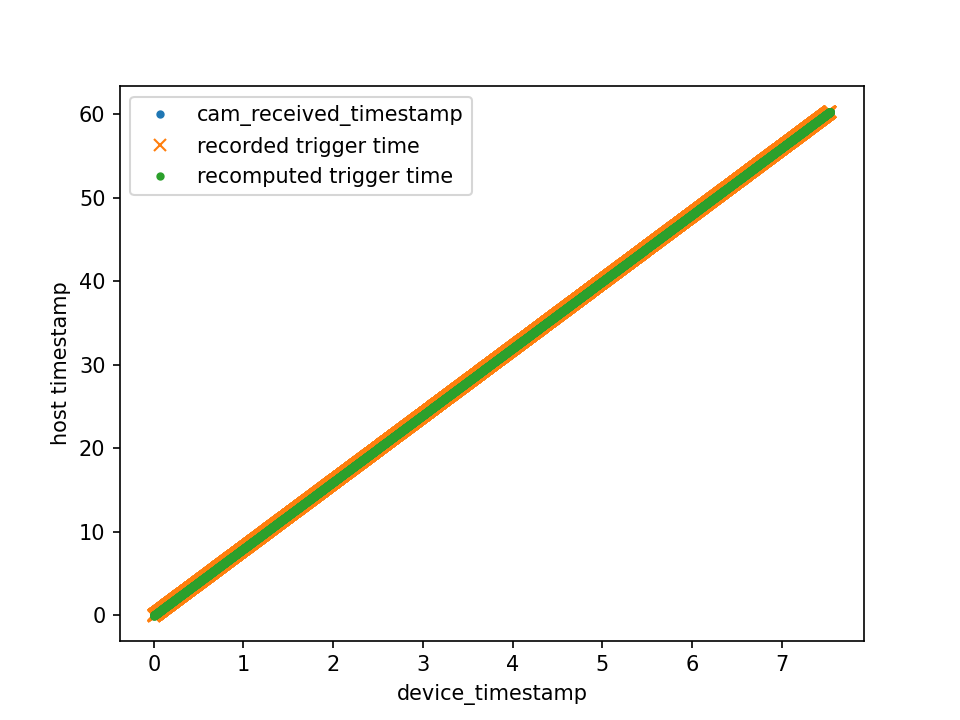

In [9]:
device_timestamp0 = df1["device_timestamp"].iloc[0]
host0_timestamp0 = df1["cam_received_timestamp"].iloc[0]

plt.figure()
plt.plot((df1["device_timestamp"]-device_timestamp0)/1e9, df1["cam_received_timestamp"]-host0_timestamp0, '.', label="cam_received_timestamp" )
plt.plot((df1["device_timestamp"]-device_timestamp0)/1e9, df1["timestamp"]-host0_timestamp0, 'x', label="recorded trigger time" )

recomputed_trigger_timestamp = (df1["frame"])*gain + offset
plt.plot((df1["device_timestamp"]-device_timestamp0)/1e9, recomputed_trigger_timestamp-host0_timestamp0, '.', label="recomputed trigger time" )

plt.xlabel("device_timestamp (sec)")
plt.ylabel("host timestamp (sec)")
plt.legend();

Now let's compute the median latency using both the recomputed and recorded frame trigger timestamps.

In [10]:
(df1["cam_received_timestamp"] - recomputed_trigger_timestamp ).median()

0.013727664947509766

In [11]:
(df["cam_received_timestamp"] - df["timestamp"]).median()

0.013857364654541016

As another check, we can plot the various timestamps as a function of frame time. The clock measurements should be very close to the recorded trigger time data and the `cam_received_timestamp` should lag by the few milliseconds required for exposure and to transfer the image to the computer.

<IPython.core.display.Javascript object>


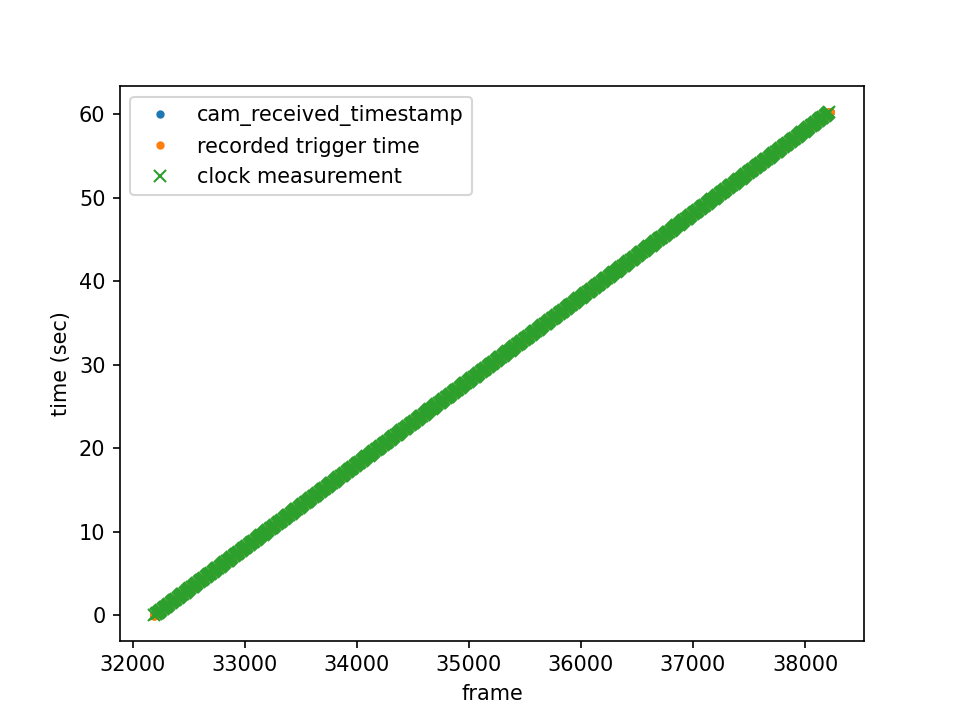

In [12]:
plt.figure()

ts0= df1["cam_received_timestamp"].iloc[0]
plt.plot(df1["frame"], df1["cam_received_timestamp"]-ts0, '.', label='cam_received_timestamp')
plt.plot(df1["frame"], df1["timestamp"]-ts0, '.', label='recorded trigger time')
plt.plot(clocks_df["framestamp"], clocks_df["timestamp"]-ts0, 'x', label='clock measurement')
plt.xlabel("frame")
plt.ylabel("time (sec)")
plt.legend();